In [1]:
# loading needed methods
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from random import seed,sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_curve, auc, precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [3]:
data = pd.read_csv('downloads/Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
data.shape

(6362620, 11)

*   There are no missing values
*   There are just over 6 million observations
*   There are 11 variables
*   Most transactions involve amounts less than 1 million euros.
*   Most observations in the dataset are of valid transactions, so any patterns related to identifying fraud transactions may be hard to see, data is also unbalanced.
*   From the sample of observations, there are many instances where what happens to the recipient account (oldbalanceDest, newbalanceDest) does not make sense (e.g. the very first observation involved a payment of 9839.64 yet, the balance before and after the transaction equals 0.)













*   No imputation is required until further notice
*   Non-parametric machine learning methods may be preferred due to the large size of the data and that the goal is accurate classification, not interpretation
*   Dimension Reduction methods may not be necessary
*   (and points 5, 6) Since the data is unbalanced I want to visually compare fraud transactions to valid transactions and see if there are any important patterns that could be useful.




One feature of the dataset is the account types "C" (customer) and "M", which would be the first character for each value under nameOrig and nameDest. Could this be a predictor?

I will create a feature "type1" which is a categorical variable with levels "CC" (Customer to Customer), "CM" (Customer to Merchant), "MC" (Merchant to Customer), "MM" (Merchant to Merchant).

In [6]:
# adding feature type1
data_new = data.copy() 
data_new["type1"] = np.nan 

# filling feature column
data_new.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('C'),"type1"] = "CC" 
data_new.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('M'),"type1"] = "CM"
data_new.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('C'),"type1"] = "MC"
data_new.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('M'),"type1"] = "MM"

In the next few code cells, I seek to compare valid transactions against fraud transactions instead of overall trends.

This is because I want to see patterns that differentiate fraud transactions from valid ones.

In [7]:
# Subsetting data into observations with fraud and valid transactions:
fraud = data_new[data_new["isFraud"] == 1]
valid = data_new[data_new["isFraud"] == 0]

# seeing the counts of transactions by type1 (CC,CM,MC,MM)
print("Fraud transactions by type1: \n",fraud.type1.value_counts())
print("\n Valid transactions by type1: \n",valid.type1.value_counts())

Fraud transactions by type1: 
 CC    8213
Name: type1, dtype: int64

 Valid transactions by type1: 
 CC    4202912
CM    2151495
Name: type1, dtype: int64


Conclusion:

From the dataset, it seems that fraud transactions only occur when the transaction type1 is CC (Customer to Customer)

Since the dataset is sample of the population, I would have resampled the data to see if this phenomenon held.

Since I do not have access to the population, I will assume that transaction only occur when transaction type1 is CC.

This also means that the datasets fraud and valid don't need to be subsetted. However, since all relevant observations have type1 = "CC", the type1 column is no longer necessary.

In [8]:
# getting rid of type1 column.

fraud = fraud.drop('type1', 1)
valid = valid.drop('type1',1)
data_new = data_new.drop('type1',1)

In [9]:
# seeing the counts of transactions by type
print("Fraud transactions by type: \n",fraud.type.value_counts())
print("\n Valid transactions by type: \n",valid.type.value_counts())

Fraud transactions by type: 
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

 Valid transactions by type: 
 CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64


Conclusion:

From the dataset, it seems that fraud transactions only occur when the transaction type is CASH_OUT or TRANSFER.

Since the dataset is sample of the population, I would've have resampled the data to see if this phenomenon held.

Since I do not have access to the population, I will assume that transaction only occur when transaction type is either CASH_OUT or TRANSFER.

In [10]:
# Subsetting data according to the conclusion above
# I don't have to subset for the fraud dataset because all of their transaction types are either TRANSFER or CASH_OUT

valid = valid[(valid["type"] == "CASH_OUT")| (valid["type"] == "TRANSFER")]
data_new = data_new[(data_new["type"] == "CASH_OUT") | (data_new["type"] == "TRANSFER")]

In [11]:
# Most, if not all, of the observations have errors in calculating the balances before and after the transaction.
wrong_orig_bal = sum(data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"])
wrong_dest_bal = sum(data["newbalanceDest"] + data["amount"] != data["newbalanceDest"])
print("Percentage of observations with balance errors in the account giving money: ", 100*round(wrong_orig_bal/len(data),2))
print("Percentage of observations with balance errors in the account receiving money: ", 100*round(wrong_dest_bal/len(data),2))

Percentage of observations with balance errors in the account giving money:  85.0
Percentage of observations with balance errors in the account receiving money:  100.0


Almost all of the observations have inaccurately portrayed what happens to the account receiving money and the account sending money.

Some form of complete or partial imputation (filling/replacing missing or wrong values) must happen.

Here are some hypothesis/assumptions that I will test soon:

There are no negative values in this dataset.
The most a given can give is how much is in their account.
The most a receiver should have in their account is the amount given to them in the transaction.

In [12]:
## Calculating some quantities to justify or reject some assumptions

# flatten the subsetted dataframe of floats into an array of floats
relevant_cols = data[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]].values.flatten()
num_neg_amt = sum(n < 0 for n in relevant_cols)
num_amt_oldgiver = sum(data["amount"] > data["oldbalanceOrg"]) 
num_amt_newreceiver = sum(data["amount"] > data["newbalanceDest"]) 

print("number of observations with negative numbers: ", num_neg_amt)
print("number of observations where the amount given is greater than the amount that is in the giver's account: ", num_amt_oldgiver)
print("number of observations where the amount received is greater than the amount that is in the receiver's account: ", num_amt_newreceiver)

#With these calculations, hypotheses 2 and 3 have been rejected.

number of observations with negative numbers:  0
number of observations where the amount given is greater than the amount that is in the giver's account:  4079080
number of observations where the amount received is greater than the amount that is in the receiver's account:  2661141


In [ ]:
# counting number of observations where oldbalanceOrg - amount != newbalanceOrig or newbalanceDest + amount != newbalanceDest
# Essentially, I am counting the number of observations where the effects of the transactions are not properly reflected
# the balances of account sending money and the account receiving money.

num_wrong_bal = (data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"]) | (data["newbalanceDest"] + data["amount"] != data["newbalanceDest"])
print("Percentage of observations with balance errors: ", 100*round(sum(num_wrong_bal)/len(data),2))

Percentage of observations with balance errors:  100.0


In fact, all observations have balance contain errors.

Since I don't know why these errors are caused, I cannot replace them.

I also don't want to get rid of the variables oldbalanceOrg, newbalanceOrig, newbalanceDest, oldbalanceDest since they might be important in identifying fraudulent transactions from valid transactions.

So for now, I will them be.

However, do these errors differ between fraudulent and valid transactions?

In [ ]:
# adding features errorBalanceOrg, errorBalanceDest
data_new["errorBalanceOrg"] = data_new.newbalanceOrig + data_new.amount - data_new.oldbalanceOrg
data_new["errorBalanceDest"] = data_new.oldbalanceDest + data_new.amount - data_new.newbalanceDest

# Subsetting data into observations with fraud and valid transactions:
fraud = data_new[data_new["isFraud"] == 1]
valid = data_new[data_new["isFraud"] == 0]
print("Summary statistics of errorBalanceOrg for fraudulent transactions: \n",fraud["errorBalanceOrg"].describe())
print("\n Summary statistics of errorBalanceOrg for valid transactions: \n",valid["errorBalanceOrg"].describe())

Summary statistics of errorBalanceOrg for fraudulent transactions: 
 count    8.213000e+03
mean     1.069233e+04
std      2.651461e+05
min     -7.450581e-09
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+07
Name: errorBalanceOrg, dtype: float64

 Summary statistics of errorBalanceOrg for valid transactions: 
 count    2.762196e+06
mean     2.868035e+05
std      8.763752e+05
min     -1.000000e-02
25%      5.261343e+04
50%      1.442008e+05
75%      2.804663e+05
max      9.244552e+07
Name: errorBalanceOrg, dtype: float64


From the summary statistics on the errorBalanceOrg, it seems that a large proportion of the data have an error of 0 or close to zero. This is indicated by the fact that the most negative error is -7.450581e-09 or  −7.450581x10−9  which is very small and close to 0, and the 3rd quartile is 0 (that is, about 75% of the data is between -7.450581e-09 and 0). However, there are some large errors, the largest error being 10,000,000.

On the other hand, for valid transactions, a large proportion of the data have large errors. For instance, about 75% of the data haver errors exceeding 52,613.43 (the first quartile). The largest error is 92,445,520.

In [ ]:
print("Summary statistics of errorBalanceDest for fraudulent transactions: \n",fraud["errorBalanceDest"].describe())
print("\n Summary statistics of errorBalanceDest for valid transactions: \n",valid["errorBalanceDest"].describe())

Summary statistics of errorBalanceDest for fraudulent transactions: 
 count    8.213000e+03
mean     7.325093e+05
std      1.867748e+06
min     -8.875516e+06
25%      0.000000e+00
50%      2.231460e+03
75%      4.427220e+05
max      1.000000e+07
Name: errorBalanceDest, dtype: float64

 Summary statistics of errorBalanceDest for valid transactions: 
 count    2.762196e+06
mean    -3.091033e+04
std      5.840943e+05
min     -7.588573e+07
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.977761e+06
Name: errorBalanceDest, dtype: float64


From the summary statistics of the errorBalanceDest variable, the errors are huge in both directions (both fraudulent and valid transactions have large positive and negative errors in the accounts where money has been moved to.)

Let's see what the differences look like when I plot errorBalanceOrg and errorBalanceDest together.

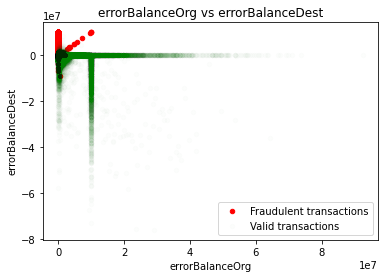

In [ ]:
errors = ["errorBalanceOrg", "errorBalanceDest"]
ax = plt.subplot()

fplot = fraud.plot(x="errorBalanceOrg",y="errorBalanceDest",color="red",kind="scatter",ax=ax,label="Fraudulent transactions")
vplot = valid.plot(x="errorBalanceOrg",y="errorBalanceDest",color="green",kind="scatter", alpha=0.01,ax=ax,label="Valid transactions")
plt.title("errorBalanceOrg vs errorBalanceDest")
plt.show()

It seems that many fraudulent transactions that are found in the top right corner where errorBalanceDest > 0, whereas transactions occur much more often when the errorBalanceDest <= 0.

In [ ]:
print("Proportion of fraudulent transactions with errorBalanceDest > 0: ", len(fraud[fraud.errorBalanceDest > 0])/len(fraud))
print("Proportion of valid transactions with errorBalanceDest > 0: ", len(valid[valid.errorBalanceDest > 0])/len(valid))
print("Proportion of fraudulent transactions with errorBalanceOrg > 0: ", len(fraud[fraud.errorBalanceOrg > 0])/len(fraud))
print("Proportion of valid transactions with errorBalanceOrg > 0: ", len(valid[valid.errorBalanceOrg > 0])/len(valid))

Proportion of fraudulent transactions with errorBalanceDest > 0:  0.5712894192134421
Proportion of valid transactions with errorBalanceDest > 0:  0.19744942067832985
Proportion of fraudulent transactions with errorBalanceOrg > 0:  0.006331425788384269
Proportion of valid transactions with errorBalanceOrg > 0:  0.9067180605576143


Conclusion:

The spread of errors in both the balanceOrg and balanceDest variables are large, however valid transactions are much more likely to have an errorBalanceOrg > 0.

Similarly, fraudulent transactions are much more likely to have errorBalanceDest > 0 than valid transactions.

In addition, only valid transactions have errorBalanceDest > 10,000,000

These distinctions and probably more, make errorBalanceDest and errorBalanceOrg potentially effective features.





In [ ]:
print("Fraud transactions by type: \n",fraud.type.value_counts())

#Clearly, fraudulent transactions exclusively involved cashouts and transfers

Fraud transactions by type: 
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


In [ ]:
pd.DataFrame.head(data_new,13)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrg,errorBalanceDest
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,0.000000e+00,181.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,0.000000e+00,21363.00
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.0,51513.44,0,0,2.138089e+05,182703.50
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.0,0.00,0,0,2.146053e+05,237735.30
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.0,2719172.89,0,0,3.008509e+05,-2401220.00
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.00,C1509514333,288800.0,2415.16,0,0,8.356930e+04,396799.55
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.00,C824009085,70253.0,64106.18,0,0,5.501188e+04,63100.72
48,1,CASH_OUT,5346.89,C512549200,0.00,0.00,C248609774,652637.0,6453430.91,0,0,5.346890e+03,-5795447.02
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.00,C2001112025,25742.0,0.00,0,0,2.849770e+03,49003.30
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.20,C1937962514,517.0,8383.29,0,0,0.000000e+00,54744.51


However, in this sample the account that the money to transferred to tends to not be the account used to make the cashout.

Let's test this statement programmatically.

In [ ]:
# separating transfers and cashouts for fraud accounts

fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]

# checking if the recipient account of a fraudulent transfer was used as a sending account for cashing out 
fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()

False

Conclusion:

Thus in this dataset, for fraudulent transactions, the account that received funds during a transfer was not used at all for cashing out.

If that is the case, there seems to be no use for nameOrig or nameDest since there seems to be no restrictions on which accounts cashout from fraudulent transactions.

Thus, I am omitting the nameOrig and nameDest columns from analysis.

In [ ]:
# getting rid of nameOrig and nameDest column.
names = ["nameOrig","nameDest"]
fraud = fraud.drop(names, 1)
valid = valid.drop(names,1)
data_new = data_new.drop(names,1)

From the overview, the variable isFlaggedFraud is described as transactions that were flagged as fraud.

To be flagged as fraud, the transaction would have to be fraudulent and involve a transfer of more than 200, 000 units in a specified currency.

With that in mind, I have some questions.

In [ ]:
# how many observations were flagged as Fraud?
flagged = data_new[data_new["isFlaggedFraud"] == 1]
flagged_correctly = sum(flagged["isFraud"] == 1)
flagged_wrongly = len(flagged) - flagged_correctly
total = flagged_correctly + flagged_wrongly
print(flagged_correctly," observations were flagged correctly and ", flagged_wrongly, \
      " observations were flagged wrongly for a total of ", total, " flagged observations.")

# how many observations where the transaction is fraudulent, the transaction is a transfer and the amount is greater 
# than 200, 000 are in the dataset
should_be_flagged = fraud[(fraud["amount"] > 200000) & (fraud["type"] == "TRANSFER")]
print("number of observations that should be flagged: ",len(should_be_flagged))

16  observations were flagged correctly and  0  observations were flagged wrongly for a total of  16  flagged observations.
number of observations that should be flagged:  2740


Conclusion:

In a modified dataset with more than 2 million observations, a variable that brings attention to only 16 observations is insignificant.

Furthermore, the number of transactions that should have been flagged far exceeds the number of observations that were actually flagged.

In addition, I am trying to develop a new fraud detection screen that does not depend on a pre-existing fraud detection scheme.

For that reason, I am omitting the isFlaggedFraud column from the analysis.

In [ ]:
# dropping isFlaggedFraud column from the fraud,valid, and new_data datasets

fraud = fraud.drop("isFlaggedFraud",1)
valid = valid.drop("isFlaggedFraud",1)
data_new = data_new.drop("isFlaggedFraud",1)

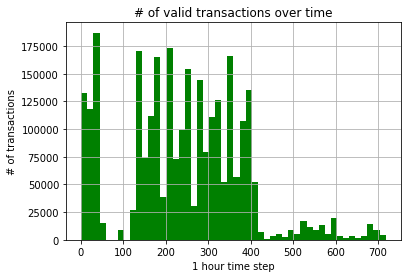

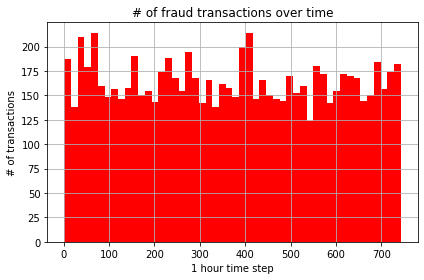

In [ ]:
# Time patterns

bins = 50

valid.hist(column="step",color="green",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

fraud.hist(column ="step",color="red",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.tight_layout()
plt.show()

There are stark difference between the step data between valid and fraud transactions.

A large proportion of valid transactions occur between around the 0th and 60th timestep as well as the 110th and 410th time-steps.
The frequency at which fraudulent transactions occur does not seem to change much over time.
However the visualizations showcase the number of transactions for each time step over the course of a month.

Let's see what the patterns look like over any particular, day of the week or hour of the day.

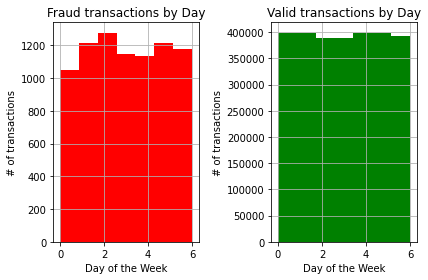

In [ ]:
# getting hours and days of the week
num_days = 7
num_hours = 24
fraud_days = fraud.step % num_days
fraud_hours = fraud.step % num_hours
valid_days = valid.step % num_days
valid_hours = valid.step % num_hours

plt.subplot(1, 2, 1)
fraud_days.hist(bins=num_days,color="red")
plt.title('Fraud transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.subplot(1,2,2)
valid_days.hist(bins=num_days,color="green")
plt.title('Valid transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

Note: With respect to days, day 0 does not necessarily mean the first day of the week, Sunday.

E.g If day 0 is Wednesday, then day 1 is Thursday, day 2 is Friday and so on...

From the graphs above, there is little evidence to suggest that fraudulent transactions occur at particular days of the week.

Much like valid transactions, fraudulent transactions seem to occur uniformally for each day of the week.

Thus I won't make a feature showing what day of the week that the transaction occured.

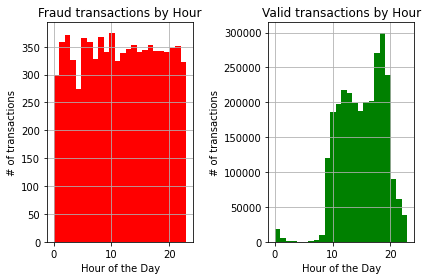

In [ ]:
plt.subplot(1, 2, 1)
fraud_hours.hist(bins=num_hours, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")


plt.subplot(1, 2, 2)
valid_hours.hist(bins=num_hours, color="green")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

Conclusion:

Note: With respect to days, hour 0 does not necessarily mean 1am in the morning.

E.g If hour 0 is 9am, then hour 1 is 10 am, hour 2 is 11am and so on...

From the graphs above, there is strong evidence to suggest that from hour 0 to hour 9 (inclusive) valid transactions very seldom occur. On the other hand, fraudulent transactions still occur at similar rates to any hour of the day outside of hours 0 to 9 (inclusive).

In response to this, I will create another feature HourOfDay, which is the step column with each number taken to modulo 24.

In [ ]:
dataset1 = data_new.copy()


# adding feature HourOfDay to Dataset1 
dataset1["HourOfDay"] = np.nan 
dataset1.HourOfDay = data_new.step % 24


print("Head of dataset1: \n", pd.DataFrame.head(dataset1))

Head of dataset1: 
     step      type     amount  ...  errorBalanceOrg  errorBalanceDest  HourOfDay
2      1  TRANSFER     181.00  ...             0.00             181.0          1
3      1  CASH_OUT     181.00  ...             0.00           21363.0          1
15     1  CASH_OUT  229133.94  ...        213808.94          182703.5          1
19     1  TRANSFER  215310.30  ...        214605.30          237735.3          1
24     1  TRANSFER  311685.89  ...        300850.89        -2401220.0          1

[5 rows x 11 columns]


In [ ]:
# Seeing summary statistics of the data

print("Summary statistics on the amounts moved in fraudulent transactions: \n",pd.DataFrame.describe(fraud.amount),"\n")
print("Summary statistics on the amounts moved in valid transactions: \n", pd.DataFrame.describe(valid.amount),"\n")

Summary statistics on the amounts moved in fraudulent transactions: 
 count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64 

Summary statistics on the amounts moved in valid transactions: 
 count    2.762196e+06
mean     3.141155e+05
std      8.771441e+05
min      1.000000e-02
25%      8.290823e+04
50%      1.710345e+05
75%      3.059942e+05
max      9.244552e+07
Name: amount, dtype: float64 



It seems that during fraudulent transactions, the amount moved is capped at 10 million currency units.

Whereas for valid transactions, the amount moved is capped at about 92.4 million currency units.

when plotting time-steps against amount moved we get this plot...

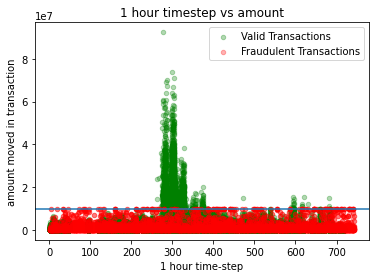

Proportion of transactions where the amount moved is greater than 10 million:  0.0008818192548464865


In [ ]:
# plotting overlayed step vs amount scatter plots

alpha = 0.3
fig,ax = plt.subplots()
valid.plot.scatter(x="step",y="amount",color="green",alpha=alpha,ax=ax,label="Valid Transactions")
fraud.plot.scatter(x="step",y="amount",color="red",alpha=alpha,ax=ax, label="Fraudulent Transactions")

plt.title("1 hour timestep vs amount")
plt.xlabel("1 hour time-step")
plt.ylabel("amount moved in transaction")
plt.legend(loc="upper right")

# plotting a horizontal line to show where valid transactions behave very differently from fraud transactions
plt.axhline(y=10000000)
plt.show()


print("Proportion of transactions where the amount moved is greater than 10 million: ", len(data_new[data_new.amount > 10000000])/len(data_new))

Conclusion:

Only valid transaction involved amounts larger than 10,000,000, however these transactions make up less than 0.01% of the relevant data.

When the amounts moved is less than 10,000,000 there doesn't seem to be a large difference fraudulent and valid transactions.

I leave the variable amount as is without creating a feature out of it.

In [ ]:
# finalizing dataset
dataset = dataset1.copy() # unchanged dataset1

# Handling Categorical Variables

Note that many algorithms require that all elements used in the computation are numbers.

For that reason, the categorical variables encoded as string must be encoded as numbers. Since there is no "order"/"hierarchy" in the type variable, the method I will use to numerically encode categorical variables is called 1 hot encoding.

One-Hot encoding involves creating indicator variables for each category in a categorical variable.

If an observation is part of a particular category (e.g. the transaction type is CASH_OUT), the indicator variable associated with the category would be 1. If it isn't part of a particular category, then the indicator variable associated with that category would be 0.

In [ ]:
# getting one-hot encoding of the 'type' variable

dataset = pd.get_dummies(dataset,prefix=['type'])

In [ ]:
pd.DataFrame.head(dataset)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,HourOfDay,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,1,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,1,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,1,0,1


# Splitting and Standardizing Data.
Similarly, many, if not all, machine learning algorithms perform better when the data is standardized/normalized (when all values are between 0 and 1 inclusive).

We will do this to standardize the data without standardizing the target variable isFraud.

Additionally, we will also split the data up into training sets and testing sets. A common split is to separate 80% of the data as the training set and the rest as the testing set. However we will rely on the "default" split which is 75% of the data is used as the training set, 25% is used as the testing set.

In [ ]:
# Setting random_state and seed so that the training/testing splits and model results are reproducible
RandomState = 42
seed(21)


# creating training and testing sets
X = dataset.drop("isFraud",1)
y = dataset.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)
    
# Normalizing data so that all variables follow the same scale (0 to 1)
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Artificial Neural Networks
Since correctly predicting fraudulent and valid transactions is the main goal and my dataset is fairly large (> 2 million rows), I think that Neural Networks would be a good choice.

In particular, I will be using a Multilayered Perceptron.

Multi Layer perceptron (MLP) is a feedforward neural network with at least 1 layer between the input and output layer. Data is trained from the input layer up until the output layer

In [ ]:
ncols = len(X.columns)
hidden_layers = (ncols,ncols,ncols)
max_iter = 1000
MLP = MLPClassifier(hidden_layer_sizes=hidden_layers,max_iter=1000,random_state=RandomState)

# training model
MLP.fit(X_train,y_train)
    
# evaluating model on how it performs on balanced datasets
predictionsMLP = MLP.predict(X_test)
CM_MLP = confusion_matrix(y_test,predictionsMLP)
CR_MLP = classification_report(y_test,predictionsMLP)
fprMLP, recallMLP, thresholdsMLP = roc_curve(y_test, predictionsMLP)
AUC_MLP = auc(fprMLP, recallMLP)
    
resultsMLP = {"Confusion Matrix":CM_MLP,"Classification Report":CR_MLP,"Area Under Curve":AUC_MLP}
# showing results from Multilayered perceptrons developed from each dataset
for measure in resultsMLP:
    print(measure,": \n",resultsMLP[measure])

Confusion Matrix : 
 [[690484     55]
 [   309   1755]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690539
           1       0.97      0.85      0.91      2064

    accuracy                           1.00    692603
   macro avg       0.98      0.93      0.95    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve : 
 0.9251055248736098


In the context of fraud detection the performance of the Neural Network isn't terrible, but it isn't great either. The loss is performance is very likely due to the phenomenon that Neural Networks perform worse when the data is imbalanced. When data is imbalanced, Neural Networks and many other models trained on the data tend to be very biased towards the majority class. In our case, the majority class are valid transactions.

This model will be the benchmark that I will compare other individual models against.

The next few models will be generated from methods that are well-known for handling imbalanced data effectively.

# Random Forest

A random forest is an algorithm that generates several decisions trees and pools the results of each tree to make a more robust prediction (Eulogio, 2017).

Another great thing about Random Forest is that I can assign weights to each class to reduced the bias of the model towards the majority class, in this case valid transaction.

In [ ]:
# Train model
parametersRF = {'n_estimators':15,'oob_score':True,'class_weight': "balanced",'n_jobs':-1,\
                 'random_state':RandomState}
RF = RandomForestClassifier(**parametersRF)
fitted_vals = RF.fit(X_train, y_train)
 
# Predict on testing set
predictionsRF = RF.predict(X_test)
 
     
# Evaluating model
CM_RF = confusion_matrix(y_test,predictionsRF)
CR_RF = classification_report(y_test,predictionsRF)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, predictionsRF)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# showing results from Random Forest

for measure in resultsRF:
    print(measure,": \n",resultsRF[measure])

Confusion Matrix : 
 [[690539      0]
 [     8   2056]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690539
           1       1.00      1.00      1.00      2064

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve : 
 0.998062015503876


As expected, the Random Forest performs much better than the Neural Networks. Instead of crowning this model as the best model, let's try another model known for performing well in imbalanced datasets.

# eXtreme Gradient Boosting Trees (or XGB trees for short)

This algorithm is well known for being used in imbalanced datasets. Similar to Random Forests, the algorithm generates several decision trees and pooling the results.

However,instead of generating multiple full blown decision trees in parallel and pooling the results, it generates multiple trees formed by weak learners sequentially and then it pools the results (Ravanshad, 2018).

As with Random Forests, I could set weights such that the model is less biased towards the majority class.

In [ ]:
# Train model
weights = (y == 0).sum() / (1.0 * (y == 1).sum()) # for unbalanced datasets, these weights are recommended
parametersXGB = {'max_depth':3,'scale_pos_weight': weights,'n_jobs':-1, 'random_state':RandomState,'learning_rate':0.1}
XGB = XGBClassifier(**parametersXGB)
    
fitted_vals = XGB.fit(X_train, y_train)
 
# Predict on testing set
predictionsXGB = XGB.predict(X_test)
 
     
# Evaluating model
CM_XGB = confusion_matrix(y_test,predictionsXGB)
CR_XGB = classification_report(y_test,predictionsXGB)
fprXGB, recallXGB, thresholds_XGB = roc_curve(y_test, predictionsXGB)
AUC_XGB = auc(fprXGB, recallXGB)
resultsXGB = {"Confusion Matrix":CM_XGB,"Classification Report":CR_XGB,"Area Under Curve":AUC_XGB}
# showing results from Extreme Gradient Boosting
for measure in resultsXGB:
    print(measure,": \n",resultsXGB[measure],"\n")

Confusion Matrix : 
 [[690424    115]
 [     7   2057]] 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690539
           1       0.95      1.00      0.97      2064

    accuracy                           1.00    692603
   macro avg       0.97      1.00      0.99    692603
weighted avg       1.00      1.00      1.00    692603
 

Area Under Curve : 
 0.9982209952783653 



# Comparing Performances

Clearly, the random forest and the extreme gradient boosted trees performed better than the neural networks, but which one is better?

Instead of comparing all of the metrics from a purely statistical or mathematical point of view, let's look at them at give some practical interpretation.

First off, let's compare their confusion matrices.

Additionally, instead of comparing the number of correct predictions, let us compare the number of wrong predictions.

In [ ]:
print("Number of valid transactions labelled as fraudulent by Random Forest: \n", CM_RF[0,1])
print("Number of valid transactions labelled as fraudulent by XGB trees: \n", CM_XGB[0,1])

Number of valid transactions labelled as fraudulent by Random Forest: 
 0
Number of valid transactions labelled as fraudulent by XGB trees: 
 115


In [ ]:
# On the basis on limiting the amount of valid transaction labelled as fraudulent, the Random Forest performed better

print("Number of fraud transactions labelled as valid by Random Forest: \n", CM_RF[1,0])
print("Number of fraud transactions labelled as valid by XGB trees: \n", CM_XGB[1,0])

Number of fraud transactions labelled as valid by Random Forest: 
 8
Number of fraud transactions labelled as valid by XGB trees: 
 7


On the basis on limiting the amount of fraudulent transactions labelled as fraudulent, the XGB trees performed better.

Based purely on the results on the confusion matrix, the better model is decided by which model incurs the lowest costs.

If the combined cost of mislabelling over 100 more valid transactions as fraudulent exceeds the cost of mislabelling a few more fraudulent transactions as valid then the random forest would be a better model.

Otherwise, the Extreme Gradient Boosted model would be superior.

Some of the other metrics tracked (precision, recall, f1-score which are found in the classification report) will convey the same information that is offered by the confusion matrix.

So what if we compared the classification reports?

In [ ]:
print("Note: scores in the same vertical level as 0 are scores for valid transactions. \n Scores in the same vertical level as 1 are scores for fraudulent transactions. \n")
print("Classification Report of Random Forest: \n", CR_RF)
print("Classification Report of XGB trees: \n", CR_XGB)

Note: scores in the same vertical level as 0 are scores for valid transactions. 
 Scores in the same vertical level as 1 are scores for fraudulent transactions. 

Classification Report of Random Forest: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690539
           1       1.00      1.00      1.00      2064

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603

Classification Report of XGB trees: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690539
           1       0.95      1.00      0.97      2064

    accuracy                           1.00    692603
   macro avg       0.97      1.00      0.99    692603
weighted avg       1.00      1.00      1.00    692603



While the recall scores for both models are identical, the Random Forest performed slightly better in terms of their precision score for fraudulent transactions.

This means that there are considerably less false positives (identifying valid transactions as fraudulent) in the Random Forest than in the XGB model. This makes sense given what we've seen in their confusion matrices (a few valid transactions labelled as fraudulent by Random Forest, compared to over 100 by the XGB model).

Based on the classification report, the Random Forest is superior.

What about AUC's (area under the curve)?

The only reason why I computed AUC's is because it is a popularly used metric to measure performance in competitions. The curve in Area Under Curve is a plot of the true positive rates (in our case, the proportion of valid transactions labelled as valid) against the false positive rate (in our case, the proportion of fraudulent transactions labelled as valid). The curve is also known as the Receiver Operating Characteristic Curve or ROC.

The ideal AUC is then 1 (all transactions predicted as valid are actually valid).


Receiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: 



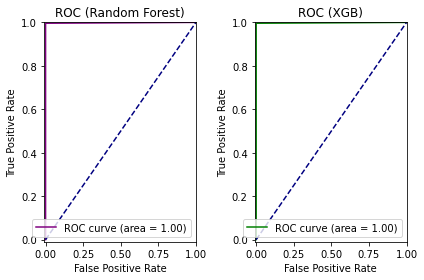


AUC of Random Forest: 
 0.998062015503876

AUC of XGB trees: 
 0.9982209952783653


In [ ]:
print("\nReceiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: \n")
plt.subplot(1, 2, 1)
plt.plot(fprRF, recallRF, color='purple', label='ROC curve (area = %0.2f)' % AUC_RF)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Random Forest)')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)
plt.plot(fprRF, recallRF, color='green', label='ROC curve (area = %0.2f)' % AUC_RF)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (XGB)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\nAUC of Random Forest: \n", AUC_RF)
print("\nAUC of XGB trees: \n", AUC_XGB)

# Receiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: 

While the AUC of the Extreme Gradient Boosted Trees is slightly greater than the AUC of the Random Forests. For all practical purposes, they are essentially the same.

Overall, I would deem the Random Forest as the superior choice because I think the cost of resolving over a 100 valid transactions labelled as fraudulent would exceed the cost of resolving a handful more fraudulent transactions that have been passed off as valid.

With that said, this may not true in actual companies. The best decision would be to consult people with experience dealing with mislabelled transactions.

Black-box/Non-parametric methods (like Neural Networks, Random Forests, Extreme Gradient Boosted Trees) are known to not be interpretable (due to having a lack of an equation to interpret from).

Nonetheless, let's take a look at what features ended up being the most important in classifying transactions.

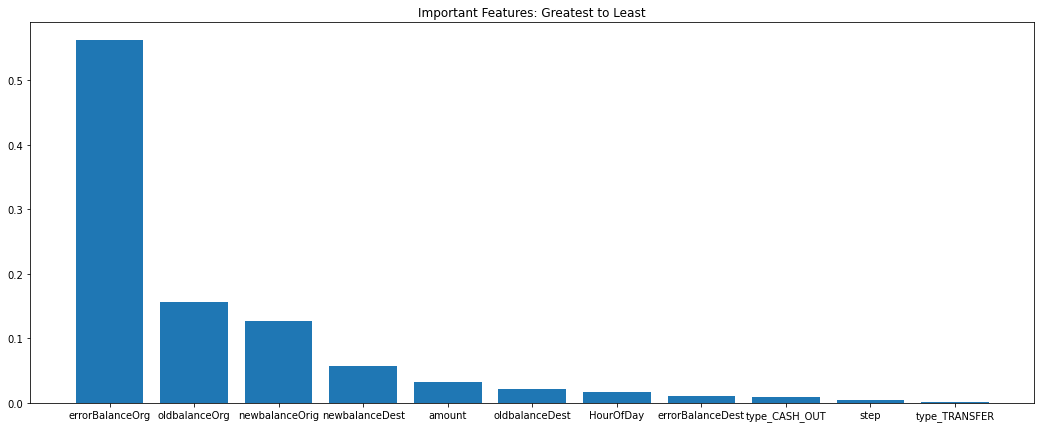

In [ ]:
x = np.arange(ncols)

# getting importances of features
importances = RF.feature_importances_

# getting the indices of the most important feature to least important
sort_ind = np.argsort(importances)[::-1]
plt.figure(figsize=(18,7))
plt.bar(x, importances[sort_ind])
plt.xticks(x,tuple(X.columns.values[sort_ind]))
plt.title("Important Features: Greatest to Least")
plt.show()

It seems that errorBalanceOrg ended by the most important feature by far for classifying transactions followed by oldBalanceOrg and newBalanceOrig.

From the exploring the dataset, we uncovered patterns that allowed us to construct important features and discard useless ones.

We applied a few popular machine learning algorithms and saw that methods that involved generating multiple decisions trees and pooling their results together performed better than Multi-Layered Perceptrons (a type of Neural Network). While it may seem that Neural Networks are unsuitable for unbalanced datasets, in some occasions, techniques such as SMOTE, oversampling and undersampling can resolve such issues.

Finally, between the Random Forests and the Extreme Gradient Boosting, practical considerations were used to decide that the Random Forests were a better model.

In particular, Random Forests were better because we thought that the cost of dealing with over a 100 wrongly labeled valid transactions is more expensive than the cost of dealing with a few additional fraudulent transactions.
